https://qard.is.tohoku.ac.jp/T-Wave/?p=1136

In [1]:
# !conda install -y attrdict tqdm

In [8]:
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pickle

import pyqubo

In [22]:
def load_data(path):
    with open(path, 'rb') as i_:
        return pickle.load(i_)

data = load_data('../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_30.pkl')

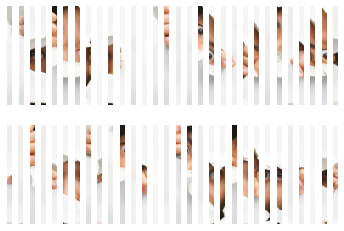

In [23]:
def show(images, rows, cols):
    fig = plt.figure()
    for i, image in enumerate(images):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.axis('off')
        ax.imshow(image)
    fig.show()

show(data.images, data.rows, data.cols)

In [24]:
def sim_x(left, right):
    shape = np.min((left.shape, right.shape), axis=0)
    return int((left[:shape[0], -1] == right[:shape[0], 0]).sum()*10/shape[0])

def sim_y(up, down):
    shape = np.min((up.shape, down.shape), axis=0)
    return int((up[-1, :shape[1]] == down[0, :shape[1]]).sum()*10/shape[1])


print(sim_x(data.images[0], data.images[1]))
print(sim_y(data.images[0], data.images[1]))

11
0


In [25]:
def build_model(data, c=1):
    x = pyqubo.Array.create('x', shape=(data.size, data.rows, data.cols), vartype='BINARY')

    costs = []
    sim = np.zeros((2, data.size, data.size))
    sim_max = [0, 0]
    for a in tqdm(range(data.size)):
        for b in range(data.size):
            if a == b:
                continue
            sim = (sim_x(data.images[a], data.images[b]), sim_y(data.images[a], data.images[b]))
            for row in range(data.rows):
                for col in range(data.cols):
                    if row < data.rows - 1:
                        if sim[1] != 0:
                            costs.append(-sim[1]*x[a, row, col]*x[b, row + 1, col])
                            sim_max[1] = max(sim_max[1], sim[1])
                    if col < data.cols - 1:
                        if sim[0] != 0:
                            costs.append(sim[0]*x[a, row, col]*x[b, row, col + 1])
                            sim_max[0] = max(sim_max[0], sim[0])

    constraint_coeff = c*(sim_max[0] + sim_max[1])
    for a in range(data.size):
        costs.append(constraint_coeff*pyqubo.Constraint((np.sum(x[a]) - 1)**2, f'img_{a}'))
    for row in range(data.rows):
        for col in range(data.cols):
            costs.append(constraint_coeff*pyqubo.Constraint((np.sum(x[:, row, col]) - 1)**2, f'pos_{row}_{col}'))
    return sum(costs).compile(), x

model, x = build_model(data)

100%|██████████| 60/60 [00:04<00:00, 14.67it/s]


In [26]:
bqm = model.to_bqm()

In [27]:
import neal

sampler = neal.SimulatedAnnealingSampler()
%time sampleset = sampler.sample(bqm, num_reads=1000)
decoded_samples = model.decode_sampleset(sampleset)
best_sample = min(decoded_samples, key=lambda x: x.energy)

CPU times: user 3min, sys: 1.53 s, total: 3min 2s
Wall time: 3min


cost: -171.0


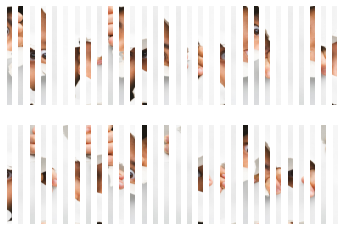

In [28]:
def is_feasible(sample):
    return all(v[0] for v in sample.constraints().values())

def show_solution(sample, data, x):
    values = np.vectorize(lambda x: sample[x.label])(x)
    pos = np.array(np.where(values == 1)).T
    images = [
        data.images[p[0]]
        for p in sorted(pos, key=lambda x: [x[1], x[2]])
    ]
    show(images[:data.size], data.rows, data.cols)

assert is_feasible(best_sample)
print(f'cost: {best_sample.energy}')
show_solution(best_sample.sample, data, x)

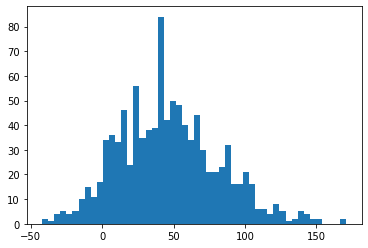

In [29]:
import matplotlib.pyplot as plt

_ = plt.hist([-sample.energy for sample in decoded_samples], bins=50)

## D-Wave Hybrid への投入

In [30]:
import hybrid

In [36]:
%%time

# Define the workflow
# iteration = hybrid.RacingBranches(
#     hybrid.InterruptableTabuSampler(),
#     hybrid.EnergyImpactDecomposer(size=2)
#     | hybrid.QPUSubproblemAutoEmbeddingSampler(qpu_sampler=sampler)
#     | hybrid.SplatComposer(),
# ) | hybrid.ArgMin()
iteration = hybrid.RacingBranches(
    hybrid.InterruptableTabuSampler(),
    hybrid.EnergyImpactDecomposer(size=10)
    | hybrid.SimulatedAnnealingSubproblemSampler()
    | hybrid.SplatComposer(),
) | hybrid.ArgMin()
workflow = hybrid.LoopUntilNoImprovement(iteration, convergence=3)

# Solve the problem
init_state = hybrid.State.from_problem(bqm)
final_state = workflow.run(init_state).result()

# Print results
#print("Solution: sample={.samples.first}".format(final_state))

CPU times: user 1min 30s, sys: 15.3 s, total: 1min 46s
Wall time: 1min 23s


In [32]:
decoded_samples = model.decode_sampleset(final_state.samples)
best_sample = min(decoded_samples, key=lambda x: x.energy)

is feasible: True
cost: -382.0


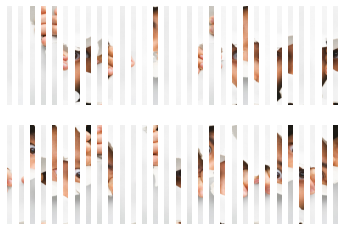

In [33]:
# assert is_feasible(best_sample)
print(f'is feasible: {is_feasible(best_sample)}')
print(f'cost: {best_sample.energy}')
show_solution(best_sample.sample, data, x)

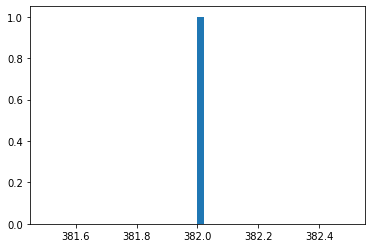

In [34]:
_ = plt.hist([-sample.energy for sample in decoded_samples], bins=50)